In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Open csv file

path = '/content/sample_data/IOT_SENSOR.csv' # Change your path here
df = pd.read_csv(path)

df.head()

,time,env_condition,Electric UV light,PM Sensor,Motion Detect,Air Q sensor,temperature,humidity,CO reading
0,1:26:00 am,warm & dry,Off,0.008,Off,0.020,25.7,51.0,0.005
1,3:50:00 am,cold & wet,Off,0.005,Off,0.013,22.7,76.0,0.003
2,6:14:00 am,warm & dry,Off,0.008,Off,0.020,24.6,50.9,0.005
3,8:38:00 am,var temp & humid,On,0.007,Off,0.019,28.0,76.8,0.004
4,11:02:00 am,warm & dry,Off,0.008,Off,0.020,26.6,50.9,0.005


# Check Imbalance of the Data (1a)

In [55]:
# Verify imbalance of the data (1a)

data = {}
for val in range(len(df['env_condition'].value_counts())):
  category = df['env_condition'].value_counts()
  data[category.index[val]] = category.values[val]

ratio_list = []
for i in range(len(data)):
  val = data[list(data.keys())[i]]/sum(data.values())
  ratio_list.append(val)
  print(f'{list(data.keys())[i]} category ratio : {val}')

if ratio_list[0] == 0.33 and ratio_list[1] == 0.33 and ratio_list[2] == 0.33:
  print('\nThe data is balanced')
else:
  print('\nThe data is imbalanced')

warm & dry category ratio : 0.46276
cold & wet category ratio : 0.2764
var temp & humid category ratio : 0.26084

The data is imbalanced


warm & dry          11569
cold & wet           6910
var temp & humid     6521
Name: env_condition, dtype: int64 



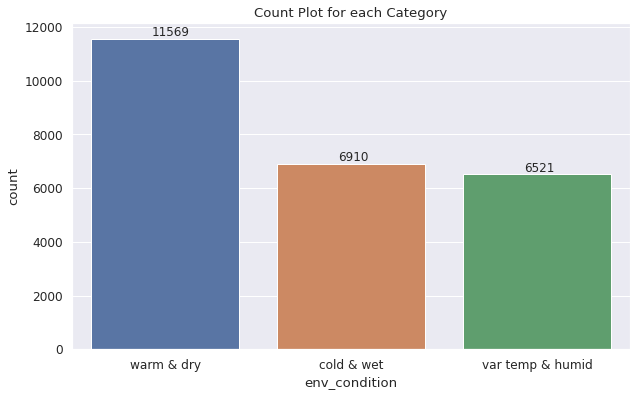

In [56]:
print(df['env_condition'].value_counts(),'\n')

plt.figure(figsize = [10,6])
sns.countplot(df['env_condition'])
plt.title('Count Plot for each Category');

text = df['env_condition'].value_counts()
for i in range(len(text)):
  plt.text(i-0.07,text.values[i] + 100,text.values[i],size = 12)

# Remove Unnecessary Variables (1b)

In [57]:
# Remove 'time' column

df = df.drop('time',axis = 1)
df.head()

,env_condition,Electric UV light,PM Sensor,Motion Detect,Air Q sensor,temperature,humidity,CO reading
0,warm & dry,Off,0.008,Off,0.020,25.7,51.0,0.005
1,cold & wet,Off,0.005,Off,0.013,22.7,76.0,0.003
2,warm & dry,Off,0.008,Off,0.020,24.6,50.9,0.005
3,var temp & humid,On,0.007,Off,0.019,28.0,76.8,0.004
4,warm & dry,Off,0.008,Off,0.020,26.6,50.9,0.005


# Correlation Matrix on each Variable (1c)

In [58]:
df.corr()

,PM Sensor,Air Q sensor,temperature,humidity,CO reading
PM Sensor,1.000000,0.009191,0.010048,-0.113421,0.377626
Air Q sensor,0.009191,1.000000,0.006545,-0.063393,-0.003663
temperature,0.010048,0.006545,1.000000,0.037915,-0.003418
humidity,-0.113421,-0.063393,0.037915,1.000000,-0.031814
CO reading,0.377626,-0.003663,-0.003418,-0.031814,1.000000


# Categorize Numerical and Categorical Variable (1d)

In [59]:
# Categorical and Numerical Variable

categorize = {}
temp_cat = []
temp_num = []
for col in df.columns:
  if type(df[col][0]) is str:
    print(f'Column {col} is Categorical Variable')
    temp_cat.append(col)
    categorize['Categorical Variable'] = temp_cat
  elif type(df[col][0]) is np.float64:
    print(f'Column {col} is Numerical Variable')
    temp_num.append(col)
    categorize['Numerical Variable'] = temp_num

Column env_condition is Categorical Variable
Column Electric UV light is Categorical Variable
Column PM Sensor is Numerical Variable
Column Motion Detect is Categorical Variable
Column Air Q sensor is Numerical Variable
Column temperature is Numerical Variable
Column humidity is Numerical Variable
Column CO reading is Numerical Variable


In [60]:
print('Numerical and Categorical Variable\n')
categorize

Numerical and Categorical Variable



{'Categorical Variable': ['env_condition',
  'Electric UV light',
  'Motion Detect'],
 'Numerical Variable': ['PM Sensor',
  'Air Q sensor',
  'temperature',
  'humidity',
  'CO reading']}

# Fill on Missing Value (1e)

In [61]:
# Check missing value on each column

index_nan = []
for col in df.columns:
  idx = df[col][df[col].isnull() == True].index
  if sum(idx) == 0:
    print(f'Column {col} has no missing value with index of missing value : \n{idx}\n')
  else:
    print(f'Column {col} has missing value with index of missing value : \n{idx}\n')

  for i in idx.values:
    index_nan.append(i)

index_nan = list(set(np.array(index_nan)))

Column env_condition has no missing value with index of missing value : 
Int64Index([], dtype='int64')

Column Electric UV light has no missing value with index of missing value : 
Int64Index([], dtype='int64')

Column PM Sensor has missing value with index of missing value : 
Int64Index([149, 259, 294, 372], dtype='int64')

Column Motion Detect has no missing value with index of missing value : 
Int64Index([], dtype='int64')

Column Air Q sensor has missing value with index of missing value : 
Int64Index([11], dtype='int64')

Column temperature has missing value with index of missing value : 
Int64Index([425, 447], dtype='int64')

Column humidity has no missing value with index of missing value : 
Int64Index([], dtype='int64')

Column CO reading has missing value with index of missing value : 
Int64Index([91, 205, 262, 325, 425, 479], dtype='int64')



In [62]:
# Calculate total of missing value in percentage

check = (len(index_nan)/df.shape[0]) * 100
if check > 5:
  print(f'Missing value has more than 5% with {check}% missing value of total number of samples\nTherefore fill missing value with mean, median or mode')
elif check < 5:
  print(f'Missing value has less than 5% with {check}% missing value of total number of samples\nTherefore remove rows with the missing data')

Missing value has less than 5% with 0.048% missing value of total number of samples
Therefore remove rows with the missing data


In [63]:
# Remove rows with the missing data

df = df.drop(index_nan, axis = 0)
df = df.reset_index()
df = df.drop('index', axis = 1)
df.head()

,env_condition,Electric UV light,PM Sensor,Motion Detect,Air Q sensor,temperature,humidity,CO reading
0,warm & dry,Off,0.008,Off,0.020,25.7,51.0,0.005
1,cold & wet,Off,0.005,Off,0.013,22.7,76.0,0.003
2,warm & dry,Off,0.008,Off,0.020,24.6,50.9,0.005
3,var temp & humid,On,0.007,Off,0.019,28.0,76.8,0.004
4,warm & dry,Off,0.008,Off,0.020,26.6,50.9,0.005


# Outlier Identification (1f)

In [64]:
# (i) Mean, median and standard deviation of numerical variable

df_numerical = df[categorize['Numerical Variable']]
df_numerical_info = df_numerical.describe().loc[['mean','50%','std']] # 50% is the median
df_numerical_info.head()

,PM Sensor,Air Q sensor,temperature,humidity,CO reading
mean,0.007325,0.020876,22.953126,64.509713,0.006044
50%,0.006796,0.018000,21.900000,74.400000,0.004000
std,0.008327,0.037416,7.359540,12.405900,0.026874


In [65]:
# (ii) Return the quantity of the outliers

def outlier(col):
  first_quartile = np.percentile(df_numerical[col],25)
  third_quartile = np.percentile(df_numerical[col],75)
  inter_quartile = third_quartile - first_quartile
  out_upper = third_quartile + (1.5 * inter_quartile)
  out_lower = first_quartile - (1.5 * inter_quartile)
  return round(out_upper,3),round(out_lower,3)

def outliercheck(checker,threshold):
  if len(checker.index) > 0:
    print(f'Found {threshold} outlier with amount of {len(checker.index)} outlier on {checker.name} column')
  elif len(checker.index) == 0:
    print(f'Found no {threshold} outlier with amount of {len(checker.index)} outlier on {checker.name} column')
  outlier_qty = len(checker.index)
  return outlier_qty

print('If some value greater than upper outlier then it will be considered as outlier')
print('If some value less than lower outlier then it will be considered as outlier\n')

outlier_quantity = {}
outlier_index = []
for col in df_numerical.columns:
  print(f'{col} columns outlier')
  print(f'Upper outlier threshold : {outlier(col)[0]}')
  print(f'Lower outlier threshold : {outlier(col)[1]}')
  upper_check = df_numerical[col][df_numerical[col] > outlier(col)[0]] # Checking upper outlier
  lower_check = df_numerical[col][df_numerical[col] < outlier(col)[1]] # Checking lower outlier on each column
#  outlier_index.append(upper_check.index.values.tolist() + lower_check.index.values.tolist())
  for otlr in upper_check.index.values.tolist() + lower_check.index.values.tolist():
    outlier_index.append(otlr)
  upper = outliercheck(upper_check,'upper')
  lower = outliercheck(lower_check,'lower')
  outlier_quantity[col] = int(upper + lower)
  print('')

outlier_index = np.array(outlier_index)

If some value greater than upper outlier then it will be considered as outlier
If some value less than lower outlier then it will be considered as outlier

PM Sensor columns outlier
Upper outlier threshold : 0.011
Lower outlier threshold : 0.002
Found upper outlier with amount of 214 outlier on PM Sensor column
Found no lower outlier with amount of 0 outlier on PM Sensor column

Air Q sensor columns outlier
Upper outlier threshold : 0.029
Lower outlier threshold : 0.005
Found upper outlier with amount of 269 outlier on Air Q sensor column
Found no lower outlier with amount of 0 outlier on Air Q sensor column

temperature columns outlier
Upper outlier threshold : 31.05
Lower outlier threshold : 13.05
Found upper outlier with amount of 272 outlier on temperature column
Found lower outlier with amount of 17 outlier on temperature column

humidity columns outlier
Upper outlier threshold : 111.95
Lower outlier threshold : 15.55
Found upper outlier with amount of 17 outlier on humidity colum

In [66]:
df_numerical_info.loc['outlier qty'] = outlier_quantity
df_numerical_info

,PM Sensor,Air Q sensor,temperature,humidity,CO reading
mean,0.007325,0.020876,22.953126,64.509713,0.006044
50%,0.006796,0.018000,21.900000,74.400000,0.004000
std,0.008327,0.037416,7.359540,12.405900,0.026874
outlier qty,214.000000,269.000000,289.000000,17.000000,186.000000


# Outlier Processing (1g)

In [67]:
# Calculate total outlier on total sample (percentage)

outlier_index_distinct = list(set(outlier_index)) # Make sure the index is not doubled
total_outlier = (len(outlier_index_distinct)/df.shape[0])*100

print(f'Total outlier found on dataset : {round(total_outlier,2)}%')

Total outlier found on dataset : 3.44%


In [68]:
# Remove outlier

if total_outlier < 5:
  print('Remove row with outlier')
  df = df.drop(outlier_index_distinct,axis = 0)
  print(df.shape)
  display(df.head())
else:
  print('Row is not removed')

Remove row with outlier
(24129, 8)


,env_condition,Electric UV light,PM Sensor,Motion Detect,Air Q sensor,temperature,humidity,CO reading
0,warm & dry,Off,0.008,Off,0.020,25.7,51.0,0.005
1,cold & wet,Off,0.005,Off,0.013,22.7,76.0,0.003
2,warm & dry,Off,0.008,Off,0.020,24.6,50.9,0.005
3,var temp & humid,On,0.007,Off,0.019,28.0,76.8,0.004
4,warm & dry,Off,0.008,Off,0.020,26.6,50.9,0.005


# Train Test Split (1h)

In [69]:
# Encode categorical variable

df_cat = df 
ord_encoder = OrdinalEncoder()

for cat in categorize['Categorical Variable']:
  df_cat[cat+'_cat'] = ord_encoder.fit_transform(df_cat[[cat]])

df = df.drop(['env_condition_cat','Electric UV light_cat','Motion Detect_cat'], axis = 1)
df_cat = df_cat[['env_condition_cat','Electric UV light_cat','PM Sensor','Motion Detect_cat','Air Q sensor', 'temperature', 'humidity', 'CO reading']]
df_cat.head()

,env_condition_cat,Electric UV light_cat,PM Sensor,Motion Detect_cat,Air Q sensor,temperature,humidity,CO reading
0,2.0,0.0,0.008,0.0,0.020,25.7,51.0,0.005
1,0.0,0.0,0.005,0.0,0.013,22.7,76.0,0.003
2,2.0,0.0,0.008,0.0,0.020,24.6,50.9,0.005
3,1.0,1.0,0.007,0.0,0.019,28.0,76.8,0.004
4,2.0,0.0,0.008,0.0,0.020,26.6,50.9,0.005


In [70]:
# Split feature and target variable

X = df_cat.drop('env_condition_cat',axis = 1)
y = df_cat[['env_condition_cat']]

X_train, X_test,y_train, y_test = train_test_split(X,y,
                                                   stratify = y,random_state = 42,
                                                   test_size = 0.2)

# Build Classification Model (2a)

In [71]:
# Define a needed function 

def accuracy(y_true,y_pred):            # User defined scoring method  (i)
  return accuracy_score(y_true,y_pred)

def normalize(train_data,test_data,normed_data = 'train'):   # User defined normalize data
  norm = Normalizer()
  norm.fit(train_data)
  if normed_data == 'train':
    data_norm = norm.transform(train_data)
  elif normed_data == 'test':
    data_norm = norm.transform(test_data)
  return data_norm

def KNN(n,X_train,X_test,y_train,y_test):             # Build KNN Model
  X_train = normalize(X_train,X_test,'train')
  knn = KNeighborsClassifier(n_neighbors = n)
  knn.fit(X_train,y_train)
  score = make_scorer(accuracy,greater_is_better = True)
  return knn,score(knn,X_train,y_train)

def LogReg(penalty,l1_ratio,X_train,X_test,y_train,y_test,solver = 'saga'):    # Build Logistic Regression Model
  X_train = normalize(X_train,X_test,'train')
  logreg = LogisticRegression(penalty = penalty,l1_ratio = l1_ratio,solver = solver)
  logreg.fit(X_train,y_train)
  score = make_scorer(accuracy,greater_is_better = True)
  return logreg,score(logreg,X_train,y_train)

method = {'K-Nearest Neighbor' : KNN, 'Logistic Regression' : LogReg}    # Dictionary for that contains two methods

In [72]:
# List score of each method using DataFrame (ii)

knn, knn_score = method['K-Nearest Neighbor'](25,X_train,X_test,y_train,y_test)
logreg, logreg_score = method['Logistic Regression']('elasticnet',1,X_train,X_test,y_train,y_test)

df_score = pd.DataFrame([[knn_score,logreg_score]],columns = [list(method.keys())[0],list(method.keys())[1]],
                        index = ['Score'])

# Identify best method based on the score (iii)
if knn_score > logreg_score:
  print('KNN is better than Logistic Regression')
elif knn_score < logreg_score:
  print('Logistic Regression is better than KNN')

display(df_score)

Logistic Regression is better than KNN


,K-Nearest Neighbor,Logistic Regression
Score,0.921411,0.921722


# Predict on Test Data (2b)

In [73]:
# Predict on test data

def predict_test(model,X_train,X_test,y_train,y_test):
  X_test = normalize(X_train,X_test,'test')
  pred = model.predict(X_test)
  score = make_scorer(accuracy,greater_is_better = True)
  return pred, score(model,X_test,y_test)

def score_predict_model(model1,score1,model2,score2):
  if score1 > score2:
    y_test_pred, score = predict_test(model1,X_train,X_test,y_train,y_test) # predict using KNN
    print(f'By using KNN, we get accuracy score of {round(score,3)}')
  elif score1 < score2:
    y_test_pred, score = predict_test(model2,X_train,X_test,y_train,y_test) # predict using LogReg
    print(f'By using Logistic Regression, we get accuracy score of {round(score,3)}')
  return y_test_pred,score

y_test_pred, score = score_predict_model(knn, knn_score,logreg, logreg_score);

df_compare = pd.DataFrame(y_test.values,index = y_test.index,columns = ['Actual (y_test)'])
df_compare['Predicted (y_test_pred)'] = y_test_pred
df_compare

By using Logistic Regression, we get accuracy score of 0.913


,Actual (y_test),Predicted (y_test_pred)
3081,0.0,2.0
2240,1.0,2.0
7576,2.0,2.0
19673,0.0,0.0
22525,1.0,1.0
...,...,...
17555,0.0,0.0
8807,1.0,1.0
1807,2.0,2.0
22036,0.0,0.0


# Confusion Matrix with Seaborn Heatmap (2c)

Confusion Matrix by using Logistic Regression


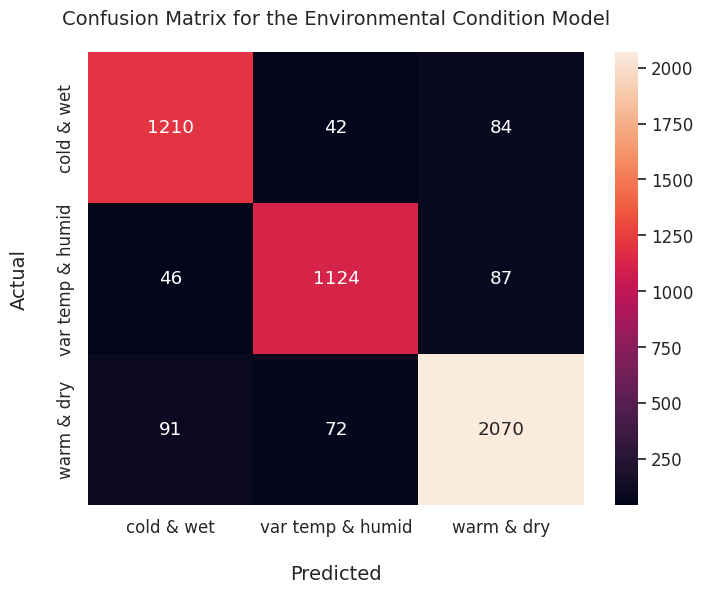

In [74]:
# Calculate confusion matrix on test data

def confmatrix_model(model1,score1,model2,score2,label):
  if score1 > score2:
    y_test_pred, score = predict_test(model1,X_train,X_test,y_train,y_test)               # predict using KNN depend on the score
    conf_matrix = confusion_matrix(y_test,y_test_pred,labels = [i for i in label.keys()])
    model = model1
    print('Confusion Matrix by using KNN')
  elif score1 < score2:
    y_test_pred, score = predict_test(model2,X_train,X_test,y_train,y_test)               # predict using LogReg depend on the score
    conf_matrix = confusion_matrix(y_test,y_test_pred,labels = [i for i in label.keys()])
    model = model2
    print('Confusion Matrix by using Logistic Regression')
  return y_test_pred, conf_matrix, model

label = {0 : 'cold & wet', 1:'var temp & humid', 2:'warm & dry'}
y_test_pred, conf_matrix, model = confmatrix_model(knn, knn_score,logreg, logreg_score,label)

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(conf_matrix, annot=True, fmt='d')

# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(label.values())

# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(label.values())

# set plot title
ax.set_title("Confusion Matrix for the Environmental Condition Model", fontsize=14, pad=20)

plt.show()

# Evaluate Model Performance (2d)

In [75]:
# Model Performance on training data

if knn_score > logreg_score:
  print('KNN is better than Logistic Regression with')
  print(f'accuracy on train data is : {knn_score}')
  print(f'accuracy on test data is : {score}')
elif knn_score < logreg_score:
  print('Logistic Regression is better than KNN with')
  print(f'accuracy on train data is : {logreg_score}')
  print(f'accuracy on test data is : {score}')

Logistic Regression is better than KNN with
accuracy on train data is : 0.921722012122468
accuracy on test data is : 0.9125569830087028


# Make Prediction based on User's Input (3a)

In [76]:
# Create DataFrame for User Input

value = ['6:00 am', 'Off', '0.0055','Off',0.013,24,80,0.004]
df_input = pd.DataFrame([value], columns = ['time'] + df.columns[1:].values.tolist())
df_input


,time,Electric UV light,PM Sensor,Motion Detect,Air Q sensor,temperature,humidity,CO reading
0,6:00 am,Off,0.0055,Off,0.013,24,80,0.004


In [77]:
def userinput_prediction(df,model,label):
  df = df.drop('time', axis = 1)
  df[categorize['Categorical Variable'][1]] = df[categorize['Categorical Variable'][1]].replace(to_replace = ['Off','On'],value = [0.0,1.0])
  df[categorize['Categorical Variable'][2]] = df[categorize['Categorical Variable'][2]].replace(to_replace = ['Off','On'],value = [0.0,1.0])
  df = df.rename(columns = {categorize['Categorical Variable'][1] : categorize['Categorical Variable'][1] + '_cat',
                            categorize['Categorical Variable'][2] : categorize['Categorical Variable'][2] + '_cat'})
  df_norm = normalize(X_train,df,'test')
  result = model.predict(df_norm)[0]
  print(f'From user input, the data is predicted and labeled as {int(result)}, which environmental condition is {label[result]}')
  return result,df_norm

# user's input data = df_input
# predict variable is the result of the predicted user's input data 
# user_data is the final result of preprocessing user's input data

predict, user_data = userinput_prediction(df_input,model,label) 

From user input, the data is predicted and labeled as 0, which environmental condition is cold & wet


# Max Probability of Class based on User's Input (3b)

In [78]:
predict_prob = model.predict_proba(user_data)[0]

for i,j in enumerate(predict_prob):
  print(f'Probability predicted on class {i} ({label[i]}) is {round(j,5)}')

print(f'\nMax probability of class based on user input is class {predict_prob.argmax()} ({label[predict_prob.argmax()]}), which value is {max(predict_prob)}')

Probability predicted on class 0 (cold & wet) is 0.70491
Probability predicted on class 1 (var temp & humid) is 0.06315
Probability predicted on class 2 (warm & dry) is 0.23193

Max probability of class based on user input is class 0 (cold & wet), which value is 0.7049148711270807
